## Data Exploration

### Where Data come from?

### What is the data about?


### When it was collected, and over what time period

### How many rows and columns

### What are the types of the columns

###  Some basic statistics and plots
     a. Plot / Pie with Major distribution
     b. Plot with race distribution
     c. Plot with work_exp
     d. Plot / Pie with work industry
     e. more??


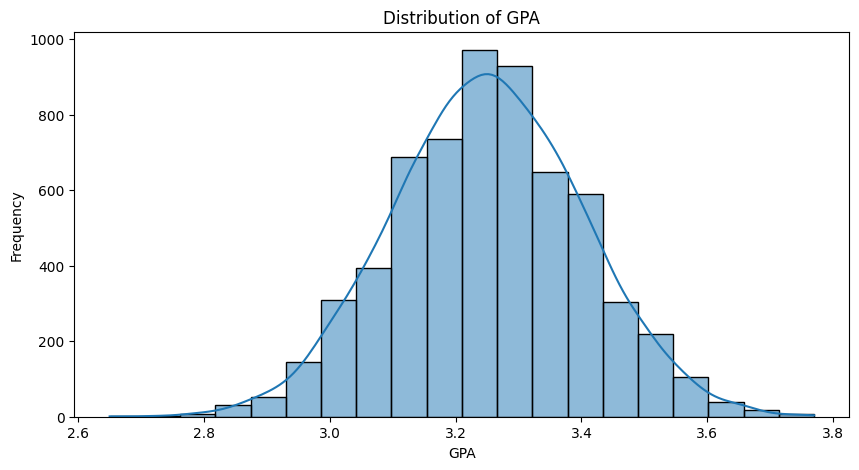

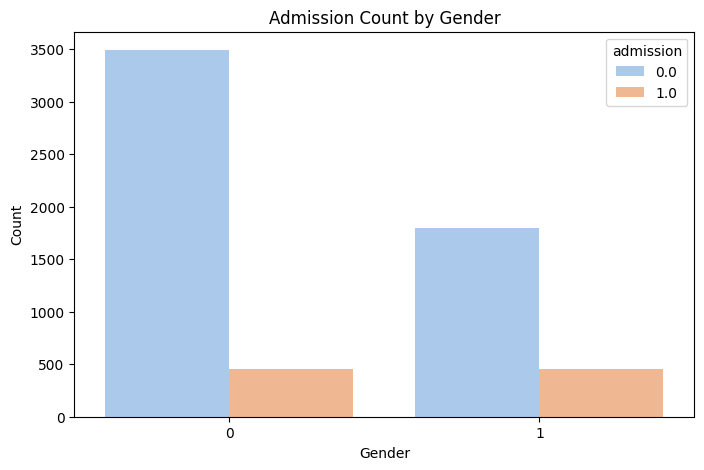

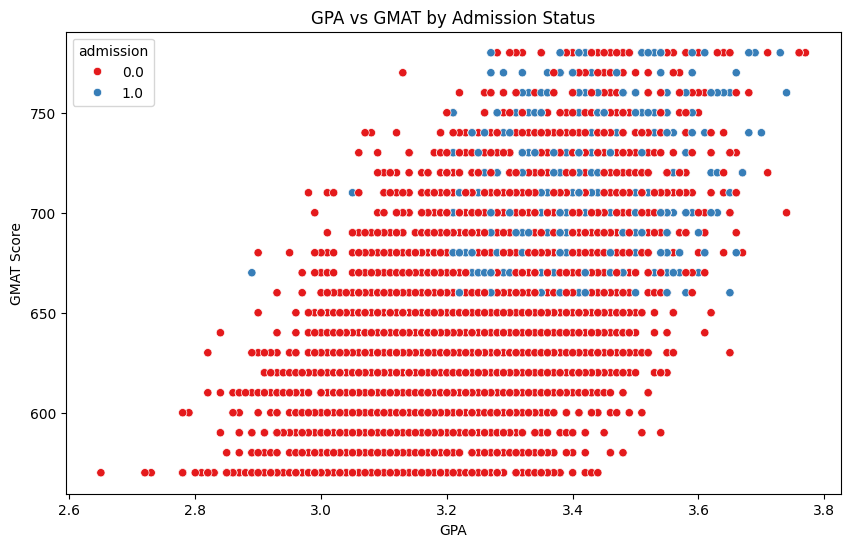

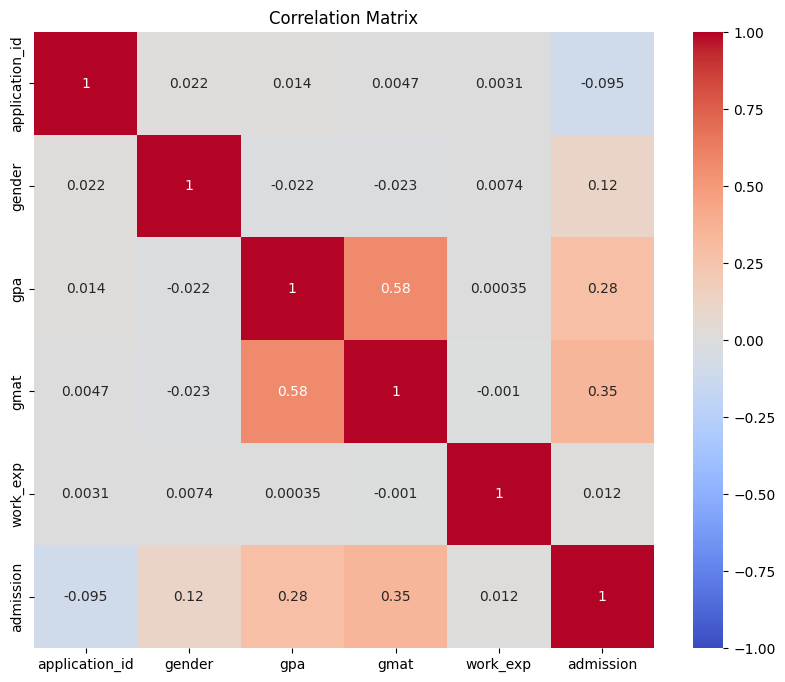

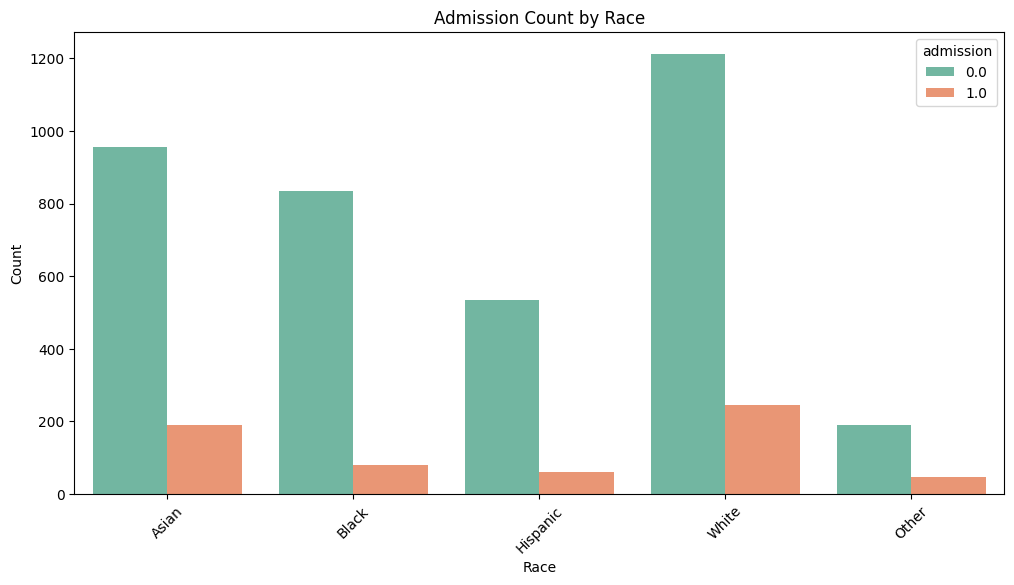

<ipython-input-14-ac5f91424073>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=admission_by_race.index, y=admission_by_race.values, palette='Set3')


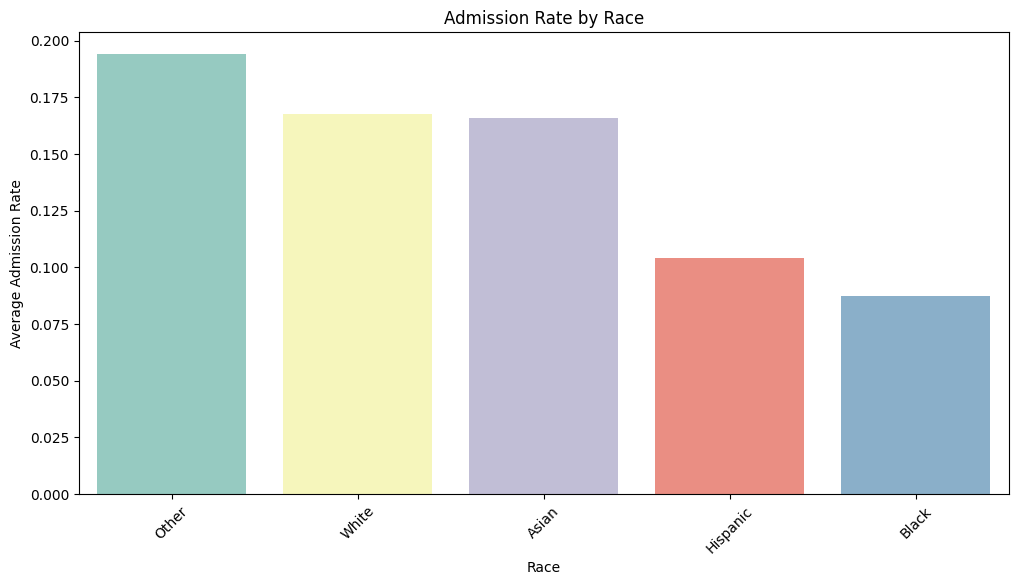

In [14]:
# Load data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

url = 'https://raw.githubusercontent.com/toutsos/ml_project/refs/heads/main/MBA.csv'
df=pd.read_csv(url)
#print(df.head())

df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['admission'] = df['admission'].map({'Admit': 1}).fillna(0)

#histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['gpa'], kde=True, bins=20)
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.show()

#admissions based on gender
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='admission', data=df, palette='pastel')
plt.title('Admission Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#GPA vs GMAT with admissions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gpa', y='gmat', hue='admission', data=df, palette='Set1')
plt.title('GPA vs GMAT by Admission Status')
plt.xlabel('GPA')
plt.ylabel('GMAT Score')
plt.show()

#heatmap
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#race
plt.figure(figsize=(12, 6))
sns.countplot(x='race', hue='admission', data=df, palette='Set2')
plt.title('Admission Count by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

admission_by_race = df.groupby('race')['admission'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=admission_by_race.index, y=admission_by_race.values, palette='Set3')
plt.title('Admission Rate by Race')
plt.xlabel('Race')
plt.ylabel('Average Admission Rate')
plt.xticks(rotation=45)
plt.show()


## Data Cleaning

### How much missing data

### What's the form of missing data?

### Where's the missing data?


### What was done about the missing data?

## Data exploration and visualization

### Various plots that are appropiate for the data.

### For every plot, the question that motivated it and what you learned from it.

## Propose ML approach

### Why specific algorithm/s?

### Is there something about the data that has driven that decision?


### Use at least 2 algorithms per person with solid alalysis of hyperparameters.

## Evaluate Performance

### Why specific metric?

### Are there alternatives?

### Use at least 2 metrics with solid explanation and performance under that metric.

## Present Results.

### Visualize the results.

### Explain plots and results carefully.

### Provide evidence of the results supporting or not supporting the goal.

### Touth on all components in the data science process.

### Did we achieve our goal?

### What we could have done better?

### What else could we do?

### What would be most impactful next step and why?

## Final Report.

### Turn in code and report document (word/pdf).

### Each people should highlight its contribution.